# Classification Models for High and Low Risk Counties

In this notebook, we will try to put our models into a practical application and use it as a predictive model. For that, we will divide the countries into high risk and low risk countries. Usually, countries with a low Corruption Perception Index (CPI) are countries that pose higher risks for business activities and foreign investments (perceived to be more corrupt). In fact, the corrupt environment in these countries could interfere with business activities and cause investment loss. To put our model (especially the regression model) into a practical usage and make a better use of numbers (than just predicting a CPI), we will divide the countries into high and low risk countries based on their CPI score. Based on our observations and EDA, and also based on the trend we have observed over time, it seems a reasonable assumption to classify countries with a CPI score below 25 as a high risk country. Now, the objective for our classifier would be to divide the countries into high and low risk counties were private investors could use our predictions to make informed decisions about whether the risk of investing in a country outweighs the rewards or not. In this type of modeling, since the cost of missclassifying high risk countries as low risk (as possibly jeopardizing their investment success) could cause costly consequences, we will try to tune our model in favor of minimizing false negatives by improving our recall score. This notebook walks us through preparing our data for classification (Gradient boosting is used as our classifier) and optimizing the model hyperparameters to achieve the desired performance based on our objective (minimizing false negatives).


In [1]:
# Import our libraries.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, recall_score, precision_score



## High and Low Risk Countries
Let us start with getting the cleaned data and removing the features that are highly correlated.

In [2]:
# read the cleaned dataset from our data cleaning step and also remove the highly correlated features 
# we found during EDA and cleaning
df = pd.read_csv('./../datasets/1860_no_null.csv')
df = df.drop(columns=['control_of_corruption', 'government_effectiveness', 'Unnamed: 0',
                      'regulatory_quality', 'rule_of_low','voice_and_accountability', 
                      'journos_imprisoned_yearly', 'gdp_per_capita_2017dollar', 'electricity_access'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1859 entries, 0 to 1858
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country                           1859 non-null   object 
 1   iso                               1859 non-null   object 
 2   year                              1859 non-null   int64  
 3   CPI                               1859 non-null   float64
 4   trade_balance_perc_of_gdp         1859 non-null   float64
 5   life_expectancy                   1859 non-null   float64
 6   inflation_annual_perc             1859 non-null   float64
 7   gini_index                        1859 non-null   float64
 8   democracy_index                   1859 non-null   float64
 9   childmor_0_5_per_1000             1859 non-null   float64
 10  cellphone_per_100                 1859 non-null   float64
 11  avrg_daily_income                 1859 non-null   float64
 12  gender

In [4]:
print(df.shape)
df.head(5)


(1859, 24)


,country,iso,year,CPI,trade_balance_perc_of_gdp,life_expectancy,inflation_annual_perc,gini_index,democracy_index,childmor_0_5_per_1000,...,political_stability,ethnic_div_index,linguistic_div_index,religious_div_index,rural_population_ratio,unemployment_perc_tot_labor,pop_percent_with_sanitation,undernourishment_prevalence_perc,population,fertility_rate
0,Finland,FIN,2006,96.0,4.160,79.6,0.921,28.0,92.5,3.64,...,1.501111,0.1315,0.1412,0.2531,16.963,7.72,99.448135,2.5,5266249.0,1.84
1,Iceland,ISL,2006,96.0,-16.700,81.7,8.620,30.3,97.1,3.07,...,1.453827,0.0798,0.0820,0.1913,6.841,2.83,98.790146,2.5,304086.0,2.09
2,New Zealand,NZL,2006,96.0,-0.386,80.0,2.690,32.5,90.1,6.46,...,1.254492,0.3969,0.1657,0.8110,13.600,3.86,100.000000,2.5,4179986.0,2.09
3,Denmark,DNK,2006,95.0,4.090,78.5,2.080,25.9,95.2,4.65,...,1.046793,0.0819,0.1049,0.2333,13.902,3.90,99.597240,2.5,5457863.0,1.85
4,Sweden,SWE,2006,92.0,6.780,81.1,1.760,26.4,98.8,3.45,...,1.293934,0.0600,0.1968,0.2342,15.570,7.07,99.063050,2.5,9104724.0,1.87


Let us take a quick look at the distribution of the CPI index again. One of the objectives for this notebook is to classify countries into high and low risk countries (based on CPI score). To do that, let us take a look at the distribution of the CPI scores again. 

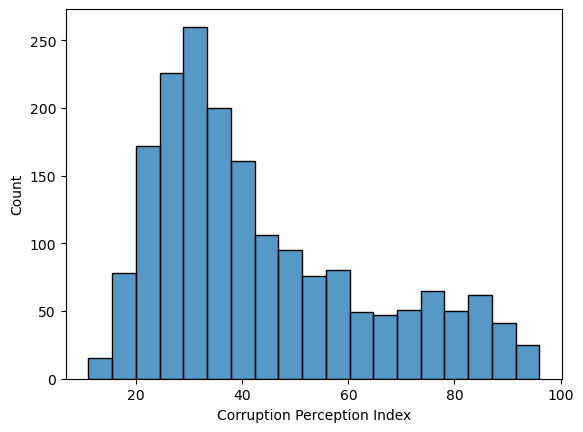

In [5]:
sns.histplot(df['CPI'])
plt.xlabel('Corruption Perception Index');

Based on what we have seen so far in the data, we will pick up a threshold of CPI = 25 for designating a country as high risk or not. Countries with CPI score more that 35 are not considered high risk but countries with a lower score will be. Let us create an additional column in our dataframe. 

In [6]:
risk_threshold = 25
df['high_risk'] = df['CPI'].apply(lambda x: 1 if x < risk_threshold else 0)
df.head(5)

,country,iso,year,CPI,trade_balance_perc_of_gdp,life_expectancy,inflation_annual_perc,gini_index,democracy_index,childmor_0_5_per_1000,...,ethnic_div_index,linguistic_div_index,religious_div_index,rural_population_ratio,unemployment_perc_tot_labor,pop_percent_with_sanitation,undernourishment_prevalence_perc,population,fertility_rate,high_risk
0,Finland,FIN,2006,96.0,4.160,79.6,0.921,28.0,92.5,3.64,...,0.1315,0.1412,0.2531,16.963,7.72,99.448135,2.5,5266249.0,1.84,0
1,Iceland,ISL,2006,96.0,-16.700,81.7,8.620,30.3,97.1,3.07,...,0.0798,0.0820,0.1913,6.841,2.83,98.790146,2.5,304086.0,2.09,0
2,New Zealand,NZL,2006,96.0,-0.386,80.0,2.690,32.5,90.1,6.46,...,0.3969,0.1657,0.8110,13.600,3.86,100.000000,2.5,4179986.0,2.09,0
3,Denmark,DNK,2006,95.0,4.090,78.5,2.080,25.9,95.2,4.65,...,0.0819,0.1049,0.2333,13.902,3.90,99.597240,2.5,5457863.0,1.85,0
4,Sweden,SWE,2006,92.0,6.780,81.1,1.760,26.4,98.8,3.45,...,0.0600,0.1968,0.2342,15.570,7.07,99.063050,2.5,9104724.0,1.87,0


In [7]:
df['high_risk'].value_counts()

0    1594
1     265
Name: high_risk, dtype: int64

Looking at the distribution of the high and low risk cases, we can say that the data shows noticeable imbalance. That is something we will have to account for during our modeling.  

## Classification Models: Accuracy vs. Recall

In this section, we will try to use gradient boosting classifiers to classify our data. 


Let us first create our X, y variables and do the train/test split. 

In [30]:
X = df.drop(columns=['country', 'iso', 'year', 'CPI', 'high_risk'])
y = df['high_risk']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=0.2,
                                                    stratify=y)

Now, let us build a gridsearch object and see how the model performs.


In [32]:
gboost_params = {
    'max_depth': [2, 3],
    'n_estimators': range(50, 201, 50),
    'learning_rate': [0.1, 0.8, 1],

}

gb_gs = GridSearchCV(GradientBoostingClassifier(random_state=42),
                     param_grid=gboost_params,
                     cv=5,
                     verbose=1)
gb_gs.fit(X_train, y_train)
preds = gb_gs.predict(X_test)
print(f'best score: {gb_gs.best_score_}')
print(f'best parameters: {gb_gs.best_params_}')
print('========')
print(f'train score: {gb_gs.score(X_train, y_train)}')
print(f'test score: {gb_gs.score(X_test, y_test)}')
print('========')
print(f'precision score: {precision_score(y_test, preds)}')
print(f'recall score: {recall_score(y_test, preds)}')
print(f'train score: {f1_score(y_test, preds)}')


Fitting 5 folds for each of 24 candidates, totalling 120 fits
best score: 0.9542675072876415
best parameters: {'learning_rate': 0.8, 'max_depth': 3, 'n_estimators': 200}
train score: 1.0
test score: 0.956989247311828
precision score: 0.8627450980392157
recall score: 0.8301886792452831
train score: 0.8461538461538461


Looking at the results, we can see that our model shows a bit of overfitting as it has a perfect accuracy on the training data with 0.96 accuracy for the test data. However, if we look at the recall score, we can see that our model is able to predict just 0.83 of the high risk cases. Please note that the data in our model is very imbalance and the model is impacted by the majority negative class. getting a recall score of 0.83 means there is a 17% chance that we have a high risk country but our model has not been able to identify it. This could have serious consequences especially when we intend to use this model as a recommender system to suggest whether a specific country pose a high risk for any future private investments or not. To alleviate this problem, we can re-run this model but this time we will try to give a higher weight to the imbalance class. 

In [45]:
gboost_params = {
    'max_depth': [2, 3, 4],
    'n_estimators': range(50, 301, 50),
    'learning_rate': [0.8, 1, 1.2],

}

# cv = 3 
gb_gs_recall = GridSearchCV(GradientBoostingClassifier(random_state=42),
                     param_grid=gboost_params,
                     cv=3, # cv = 3 used in some cases to shorten the run time
#                     scoring='recall',
                     verbose=1)

sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = 1
sample_weights[y_train == 1] = 30

gb_gs_recall.fit(X_train, y_train, sample_weight=sample_weights)
preds = gb_gs_recall.predict(X_test)
print(f'best score: {gb_gs_recall.best_score_}')
print(f'best parameters: {gb_gs_recall.best_params_}')
print('========')
print(f'train score: {gb_gs_recall.score(X_train, y_train)}')
print(f'test score: {gb_gs_recall.score(X_test, y_test)}')
print('========')
print(f'precision score: {precision_score(y_test, preds)}')
print(f'recall score: {recall_score(y_test, preds)}')
print(f'train score: {f1_score(y_test, preds)}')

Fitting 3 folds for each of 54 candidates, totalling 162 fits
best score: 0.9509001303356142
best parameters: {'learning_rate': 0.8, 'max_depth': 3, 'n_estimators': 250}
train score: 1.0
test score: 0.9516129032258065
precision score: 0.7966101694915254
recall score: 0.8867924528301887
train score: 0.8392857142857143


Referring to the results, we can see that by adding more weights to the minority class, our model is able to perform slightly better in decreasing the false negative cases (improved recall score from 0.83 to 0.89). However, it has to be added that before adding sample weights to the minority class, we tried to optimize the GridsearchCV results based on recall score (instead of the default accuracy score) but that approach did not result in any improvement in our recall score.

## Key Takeaways
- In this section, we have reframed our problem definition into a classification problem to use the model as a predictor for high and low risk countries.
- Recall score was used as our metric since the outcome of the model would be to identify countries with a high corruption perception or high risk countries. 
- Gradient boost was used as our classifier and since the data showed a significant imbalance, we opt to use specific a treatment for it.
- By increasing the weight for the minority class, we were able to improve our model's performance on the minority class and boosted the recall score close to 0.90 on our test data. 
